# Log
- Written by Junhyeon Kang / email: junhyeon@tesser.co.kr
- Written date: 20230711


---------

# Code Description
- Edits common errors in hair annotation XML-files

-------

# Code Flow
- Load annotation data
- Resize and square pores
- Make all hair boxes rectangular
- Check for Truncated
- Check for correct rotation
- Delete empty pores, Mark unmatched hairs
- Cluster into nearby hair boxes
- Check for repetitive boxes
- Check for iscrowd
- Create histograms of different types of errors
- Write to new edited XML-file

------------

# Package Import

In [1]:
import xml.etree.ElementTree as ET
import os, shutil
import math
import matplotlib.pyplot as plt
import numpy as np
from shapely import Polygon

In [2]:
finaltree = ET.parse('C:/Users/junhy/Documents/vscode/batch1_0719.xml')
finalroot = finaltree.getroot()
finalroot

<Element 'annotations' at 0x00000205128C1B70>

-----

# Util Functions

In [3]:
def centroidof(box):
    x = (float(box.attrib['xbr']) + float(box.attrib['xtl'])) / 2
    y = (float(box.attrib['ybr']) + float(box.attrib['ytl'])) / 2
    return x,y

In [4]:
def actual_coord(box):
    '''
    Input: box Element
    Returns: Actual 8 coordinates of box (accounting for rotation)
    '''
    degree_angle = float(box.attrib['rotation'])
    angle = degree_angle/180 * math.pi
    w = float(box.attrib['xbr']) - float(box.attrib['xtl'])
    h = -(float(box.attrib['ytl']) - float(box.attrib['ybr'])) # origin at top left corner
    cx, cy = centroidof(box)
    x1 = cx + (w / 2) * math.cos(angle) - (h / 2) * math.sin(angle)
    y1 = cy + (w / 2) * math.sin(angle) + (h / 2) * math.cos(angle)
    x2 = cx - (w / 2) * math.cos(angle) - (h / 2) * math.sin(angle)
    y2 = cy - (w / 2) * math.sin(angle) + (h / 2) * math.cos(angle)
    x3 = cx - (w / 2) * math.cos(angle) + (h / 2) * math.sin(angle)
    y3 = cy - (w / 2) * math.sin(angle) - (h / 2) * math.cos(angle)
    x4 = cx + (w / 2) * math.cos(angle) + (h / 2) * math.sin(angle)
    y4 = cy + (w / 2) * math.sin(angle) - (h / 2) * math.cos(angle)

    return x1,y1,x2,y2,x3,y3,x4,y4

In [5]:
def in_pore(target_coordinate, box):
    '''
    Returns whether target_coordinate tuple (x,y) is inside box
    '''
    if float(box.attrib['xtl']) < target_coordinate[0] < float(box.attrib['xbr']):
        if float(box.attrib['ytl']) < target_coordinate[1] < float(box.attrib['ybr']):
            return True
    return False

In [6]:
def are_neighbors(point1, point2):
    '''
    Inputs: tuples (x coordinate, y coordinate)
    Returns: Boolean whether the two points are close
    '''
    xdist = point1[0] - point2[0]
    ydist = point1[1] - point2[1]
    dist = math.sqrt(xdist**2 + ydist**2)
    
    return dist < 120

In [7]:
def are_same(box1, box2):
    '''
    Inputs: two boxes
    Returns: whether the two boxes are nearly same
    '''
    w1 = float(box1.attrib['xbr']) - float(box1.attrib['xtl'])
    h1 = -(float(box1.attrib['ytl']) - float(box1.attrib['ybr'])) # origin at top left corner
    cx1 = float(box1.attrib['xbr']) - w1/2
    cy1 = float(box1.attrib['ybr']) - h1/2
    w2 = float(box2.attrib['xbr']) - float(box2.attrib['xtl'])
    h2 = -(float(box2.attrib['ytl']) - float(box2.attrib['ybr'])) # origin at top left corner
    cx2 = float(box2.attrib['xbr']) - w2/2
    cy2 = float(box2.attrib['ybr']) - h2/2    
    
    cdist = math.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)

    if cdist < 3:
        if float(box1.attrib['rotation']) - 8 < float(box2.attrib['rotation']) < float(box1.attrib['rotation']) + 8:
            return True
    return False

In [8]:
def overlap(box1, box2):
    '''
    Inputs: two boxes
    Returns: whether the two boxes overlap
    '''
    x1,y1,x2,y2,x3,y3,x4,y4 = actual_coord(box1)
    polygon1 = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4)])

    x1,y1,x2,y2,x3,y3,x4,y4 = actual_coord(box2)
    polygon2 = Polygon([(x1,y1), (x2,y2), (x3,y3), (x4,y4)])

    return polygon1.intersects(polygon2)

-------------

### Histogram data

In [9]:
imageswitherror = []

imageswith_rectangleerror = []
imageswith_truncatederror = []
imageswith_rotationerror = []
imageswith_unmatchederror = []
imageswith_repetitionerror = []
imageswith_iscrowderror = []

------------

# Square Pores between 20 and 40

In [10]:
final_image_list = finalroot.findall('image')

for image in final_image_list:
    box_list = image.findall('box')
    for box in box_list:        
        if box.attrib['label'] == 'pore':
            box.attrib['rotation'] = '0.0'
            
            boxwidth = float(box.attrib['xbr']) - float(box.attrib['xtl'])
            boxheight = - float(box.attrib['ytl']) + float(box.attrib['ybr'])
            maxdim = max(min(boxwidth, boxheight, 60), 20) # keep max dim of rectangle, but within boundaries 20 ~ 60
            
            width_change = maxdim - boxwidth
            height_change = maxdim - boxheight

            box.attrib['xbr'] = str(float(box.attrib['xbr']) + width_change / 2)
            box.attrib['xtl'] = str(float(box.attrib['xtl']) - width_change / 2)

            box.attrib['ybr'] = str(float(box.attrib['ybr']) + height_change / 2)
            box.attrib['ytl'] = str(float(box.attrib['ytl']) - height_change / 2)

            


---------

# Make width always longer than height

In [11]:
final_image_list = finalroot.findall('image')
count = 0

for image in final_image_list:
    box_list = image.findall('box')
    for box in box_list:        
        if box.attrib['label'] == 'terminal':            
            boxwidth = float(box.attrib['xbr']) - float(box.attrib['xtl'])
            boxheight = - float(box.attrib['ytl']) + float(box.attrib['ybr'])
            
            if boxwidth < boxheight: # tall rectangular shape (which we don't want)
                new_angle = float(box.attrib['rotation']) + 90
                if new_angle > 360:
                    new_angle -= 360

                box.attrib['rotation'] = str(new_angle)
                box.attrib['xtl'] = str(float(box.attrib['xtl']) - (boxheight - boxwidth)/2)
                box.attrib['xbr'] = str(float(box.attrib['xbr']) + (boxheight - boxwidth)/2)
                box.attrib['ytl'] = str(float(box.attrib['ytl']) + (boxheight - boxwidth)/2)
                box.attrib['ybr'] = str(float(box.attrib['ybr']) - (boxheight - boxwidth)/2)
                count += 1
                imageswitherror.append(int(image.attrib['id']))
                imageswith_rectangleerror.append(int(image.attrib['id']))
print(count)

5


--------------

# Check Rotation, then unmatched hairs and empty pores

In [12]:
final_image_list = finalroot.findall('image')

lonehair = 0
count = 0
for image in final_image_list:
    box_list = image.findall('box')

    pore_dic = dict()
    for box in box_list:
        # Make sure every box has rotation annotation
        if 'rotation' not in box.attrib.keys(): 
            box.attrib['rotation'] = '0.0'
            
        if box.attrib['label'] == 'pore':
             # List all pores in image as unvisited
            pore_dic[box] = False


    # Iterate through all hair boxes
    for box in box_list:
        # If terminal/vellus/portion
        if box.attrib['label'] in {'terminal', 'vellus', 'portion'}:

            # Find actual coordinates
            cx,cy = centroidof(box)
            x1,y1,x2,y2,x3,y3,x4,y4 = actual_coord(box)

            # Find corresponding pore (two or one coordinates inside pore box)
            poreswithtwo_info = set()
            poreswithone_info = set()
            
            for pore in pore_dic.keys():
                if (in_pore((x1,y1), pore) and in_pore((x4,y4), pore)): # point 1 and point 4 in pore
                    xinpore = (x1+x4)/2
                    yinpore = (y1+y4)/2
                    poreswithtwo_info.add((pore, xinpore, yinpore))
                    pore_dic[pore] = True # mark pore as visited

                elif (in_pore((x2,y2), pore) and in_pore((x3,y3), pore)): # point 2 and point 3 in pore
                    xinpore = (x2+x3)/2
                    yinpore = (y2+y3)/2
                    poreswithtwo_info.add((pore, xinpore, yinpore)) 
                    pore_dic[pore] = True # mark pore as visited
                
                else: # two end points are not in pore
                    if in_pore((x1,y1), pore) or in_pore((x4,y4), pore): 
                        xinpore = (x1+x4)/2 # midpoint that should be in pore
                        yinpore = (y1+y4)/2
                        poreswithone_info.add((pore, xinpore, yinpore)) 
                        pore_dic[pore] = True # mark pore as visited

                    if in_pore((x2,y2), pore) or in_pore((x3,y3), pore): 
                        xinpore = (x2+x3)/2
                        yinpore = (y2+y3)/2
                        poreswithone_info.add((pore, xinpore, yinpore))
                        pore_dic[pore] = True # mark pore as visited

            # Fixing Orientation
            skipflag = False

            if len(poreswithtwo_info) == 1: # porewithtwo considered as priority
                poreinfo = poreswithtwo_info.pop()
                pore = poreinfo[0]
                xinpore = poreinfo[1]
                yinpore = poreinfo[2]

            elif len(poreswithtwo_info) > 1:
                skipflag = True # ignore that terminal with multiple two-pores

            elif len(poreswithone_info) == 1: 
                poreinfo = poreswithone_info.pop()
                pore = poreinfo[0]
                xinpore = poreinfo[1]
                yinpore = poreinfo[2]

            elif len(poreswithone_info) > 1:
                skipflag = True # ignore that terminal with multiple one-pores

            else: # no points within any pore (lonely hair)
                count += 1
                lonehair += 1
                imageswitherror.append(int(image.attrib['id']))
                imageswith_unmatchederror.append(int(image.attrib['id']))
                skipflag = True # ignore


            if not skipflag:
                porew = float(pore.attrib['xbr']) - float(pore.attrib['xtl'])
                porecx = float(pore.attrib['xbr']) - porew/2
                porecy = float(pore.attrib['ybr']) - porew/2
                degree_angle = float(box.attrib['rotation'])

                if cy < yinpore and degree_angle > 180: # terminal pointing above pore
                    box.attrib['rotation'] = str(degree_angle - 180)
                    count += 1
                    imageswitherror.append(int(image.attrib['id']))
                    imageswith_rotationerror.append(int(image.attrib['id']))

                elif cy > yinpore and degree_angle < 180: # terminal pointing below pore
                    box.attrib['rotation'] = str(degree_angle + 180)
                    count += 1
                    imageswitherror.append(int(image.attrib['id']))
                    imageswith_rotationerror.append(int(image.attrib['id']))

                elif cy == yinpore: # terminal at same level with pore
                    if cx > xinpore: # terminal at right of pore
                        box.attrib['rotation'] = '180.0'
                        
                    else: # terminal at left of pore
                        box.attrib['rotation'] = '0.0'

    # Remove unmatched pores    
    for pore in pore_dic:
        if pore_dic[pore] == False:
            count += 1
            imageswitherror.append(int(image.attrib['id']))
            imageswith_unmatchederror.append(int(image.attrib['id']))
            image.remove(pore)

print('count: ',count)
print('lonehair: ', lonehair)

count:  852
lonehair:  197


------------

# Fix Height-Width Ratio

In [13]:
for image in final_image_list:
    box_list = image.findall('box')
    for box in box_list:
        if box.attrib['label'] != 'pore': # all hair boxes
            ytl = float(box.attrib['ytl'])
            ybr = float(box.attrib['ybr'])
            xbr = float(box.attrib['xbr'])
            xtl = float(box.attrib['xtl'])
            degree_angle = float(box.attrib['rotation'])
            angle = degree_angle/180 * math.pi
            h = ybr - ytl
            w = xbr - xtl
            cx = xbr - w/2
            cy = ybr - h/2
            
            if box.attrib['label'] == 'vellus':
                new_w = h*15
            else:
                new_w = h*5

            w_change = w - new_w # positive for shorten

            # Shorten and Lengthen 
            cy += math.sin(angle) * w_change/2
            cx += math.cos(angle) * w_change/2
            xbr = cx + new_w/2
            xtl = cx - new_w/2
            ybr = cy + h/2
            ytl = cy - h/2
            
            box.attrib['xbr'] = str(xbr)
            box.attrib['xtl'] = str(xtl)
            box.attrib['ybr'] = str(ybr)
            box.attrib['ytl'] = str(ytl)

# Check for TRUNCATED

In [14]:
final_image_list = finalroot.findall('image')

count = 0
for image in final_image_list:
    box_list = image.findall('box')

    for box in box_list:
            
        if box.attrib['label'] == 'terminal' or box.attrib['label'] == 'vellus':
            # Find actual coordinates
            x1,y1,x2,y2,x3,y3,x4,y4 = actual_coord(box)

            # Check truncated if a coordinate is outside of image
            if min(x1, y1, x2, y2, x3, y3, x4, y4) < 0 or max(x1,x2,x3,x4) > 640 or max(y1,y2,y3,y4) > 480:
                attribute_list = box.findall('attribute')
                for attribute in attribute_list:
                    if attribute.attrib['name'] == 'truncated' and attribute.text == 'false':
                        count += 1
                        attribute.text = 'true'
                        imageswitherror.append(int(image.attrib['id']))
                        imageswith_truncatederror.append(int(image.attrib['id']))

print(count)
        

2105


-----------

# Cluster, then delete repetition and check iscrowd

In [15]:
newcount = 0

# make a set of all hair boxes with their centroids
for image in final_image_list:
    box_list = image.findall('box')
    hairbox_list = []
    grouped_list = []

    for box in box_list:
        if box.attrib['label'] != 'pore': # if hair box
            hairbox_list.append(box)
    
    while hairbox_list:
        reference = hairbox_list.pop()
        thisgroup = {reference}
        for box in hairbox_list:
            if are_neighbors(centroidof(box), centroidof(reference)):
                thisgroup.add(box)

        grouped_list.append(thisgroup)
        hairbox_list = [box for box in hairbox_list if box not in thisgroup]
        

#  Check if two boxes are almost the same
    for group in grouped_list:
        group = list(group)
        pointer1 = 0
        for pointer1, box1 in enumerate(group):
            for pointer2, box2 in enumerate(group[pointer1+1:]):
                if are_same(box1, box2):
                    imageswitherror.append(int(image.attrib['id']))
                    imageswith_repetitionerror.append(int(image.attrib['id']))
                    
                    if box1.attrib['label'] != box2.attrib['label']: # if different labels, mostly vellus
                        if box1.attrib['label'] == 'terminal':
                            image.remove(box1)
                        else: # box2 is the terminal
                            image.remove(box2)
                    else: # both terminals or both velluses
                        image.remove(box2) # arbitrary selection                

                elif overlap(box1,box2) == True: # both boxes should be isCrowd
                    attribute_list = box1.findall('attribute')
                    for attribute in attribute_list:
                        if attribute.attrib['name'] == 'iscrowd' and attribute.text == 'false':
                            newcount += 1
                            count += 1
                            attribute.text = 'true'
                            imageswitherror.append(int(image.attrib['id']))
                            imageswith_iscrowderror.append(int(image.attrib['id']))

                    
                    attribute_list = box2.findall('attribute')
                    for attribute in attribute_list:
                        if attribute.attrib['name'] == 'iscrowd' and attribute.text == 'false':
                            newcount += 1
                            count += 1
                            attribute.text = 'true'
                            imageswitherror.append(int(image.attrib['id']))
                            imageswith_iscrowderror.append(int(image.attrib['id']))
                            
print('iscrowd errors: ', newcount)
print('accumulated errors: ', count)

iscrowd errors:  7682
accumulated errors:  9787


-----

## Make into Integers

In [16]:
for image in final_image_list:
    box_list = image.findall('box')

    for box in box_list:
        box.attrib['xbr'] = str(round(float(box.attrib['xbr'])))
        box.attrib['xtl'] = str(round(float(box.attrib['xtl'])))
        box.attrib['ybr'] = str(round(float(box.attrib['ybr'])))
        box.attrib['ytl'] = str(round(float(box.attrib['ytl'])))
        

In [20]:
a = list(set(imageswith_rectangleerror))
a.sort()
a

[168, 519, 674, 790, 833]

# Histograms

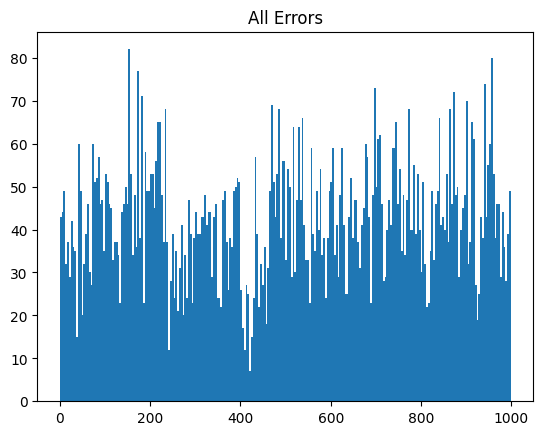

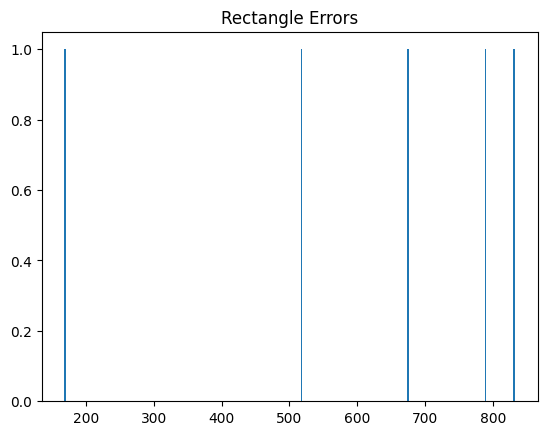

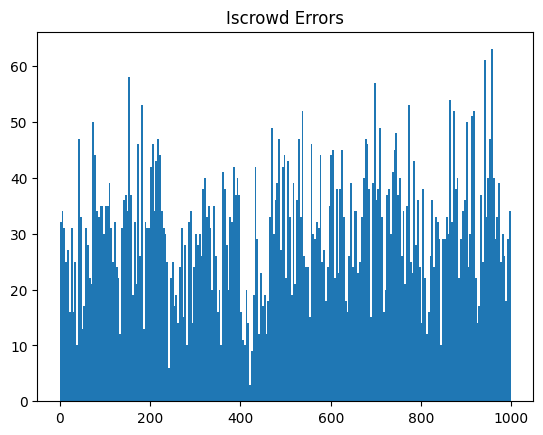

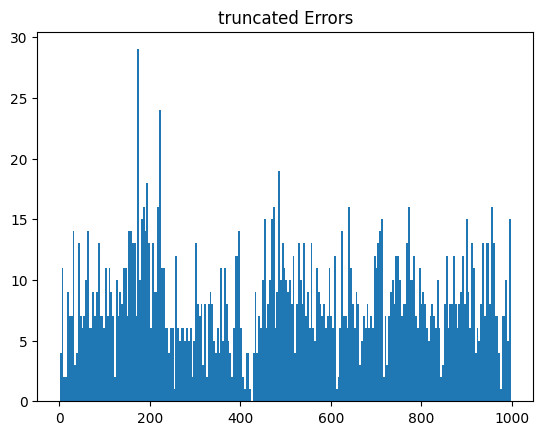

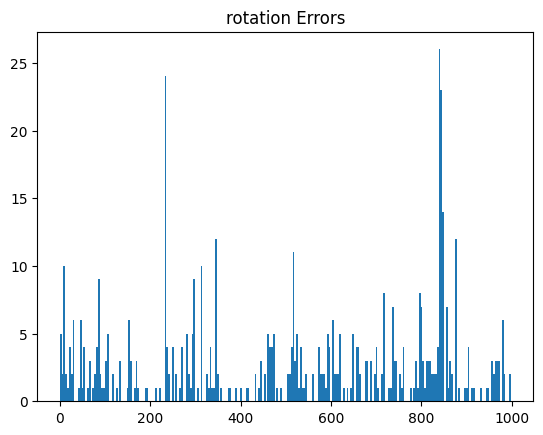

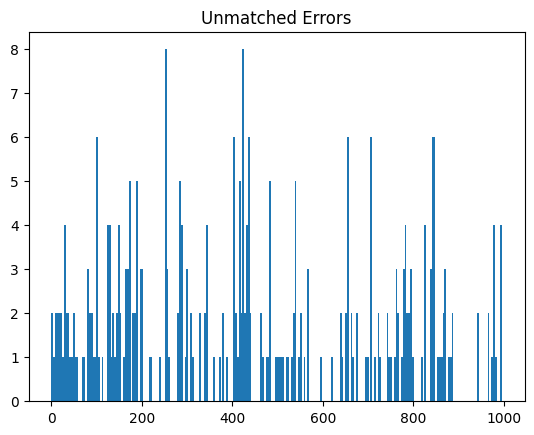

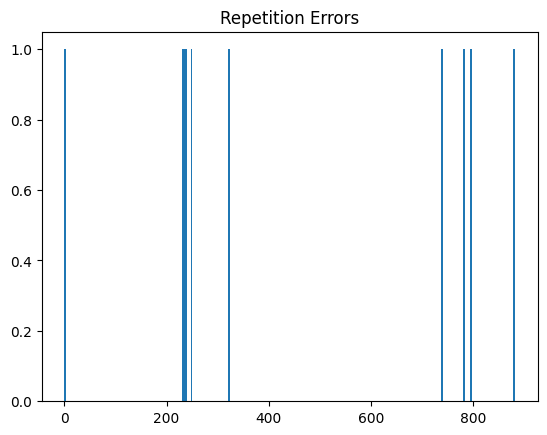

In [18]:
plt.hist(imageswitherror, bins=250)
plt.title('All Errors')
plt.show()

plt.hist(imageswith_rectangleerror, bins=250)
plt.title('Rectangle Errors')
plt.show()

plt.hist(imageswith_iscrowderror, bins=250)
plt.title('Iscrowd Errors')
plt.show()

plt.hist(imageswith_truncatederror, bins=250)
plt.title('truncated Errors')
plt.show()

plt.hist(imageswith_rotationerror, bins=250)
plt.title('rotation Errors')
plt.show()

plt.hist(imageswith_unmatchederror, bins=250)
plt.title('Unmatched Errors')
plt.show()

plt.hist(imageswith_repetitionerror, bins=250)
plt.title('Repetition Errors')
plt.show()


# Write to new file

In [19]:
new_xml = ET.tostring(finalroot)
with open('batch1_stage2.xml', 'wb') as f:
    f.write(new_xml)